In [1]:
@time begin
using Gen, Distributions
using StatsPlots
using StatsBase
using DataFrames
plotlyjs()
end

WebIO._IJuliaInit()

 12.046501 seconds (48.36 M allocations: 3.079 GiB, 4.80% gc time, 34.64% compilation time)


Plots.PlotlyJSBackend()

# Choosing a Restaurant

# Chasing friends

In [2]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/planning.jl");
include("../inverse-planning/viz.jl");

In [3]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.50, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.60), 0.50, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.40), 0.05, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.57), 0.05, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.60), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.70), 0.10, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.30), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.30), 0.10, wall_thickness));


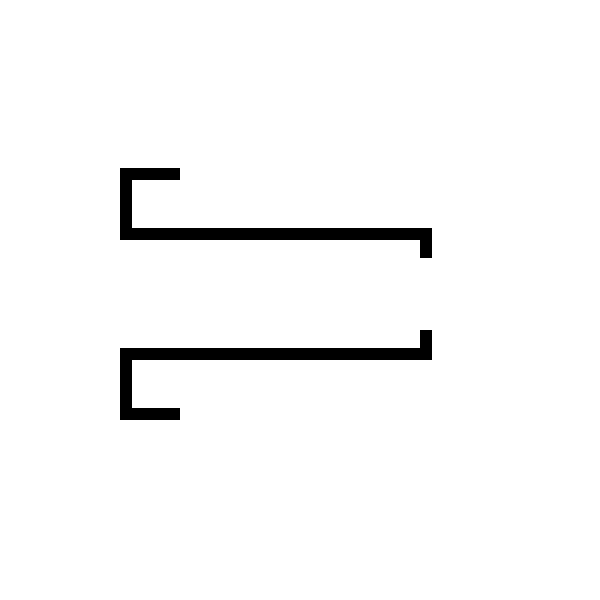

In [4]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [5]:
@gen function restaurant_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/3, 1/3, 1/3])
    dest_xs = [0.25, 0.25, 0.9]
    dest_ys = [0.65, 0.35, 0.9]
    dest_x ~ normal(dest_xs[restaurant], 0.0125)
    dest_y ~ normal(dest_ys[restaurant], 0.0125)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

In [6]:
speed = 1.
dt = 0.1
num_ticks = 10;

In [7]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int, model=walk_model)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, = importance_resampling(model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    
    return trace
end;

In [8]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000, num_ticks=num_ticks, draw_measurements=true, draw_path=false, statistics=false, restaurant_visits=zeros(3), model=walk_model)
    if statistics
        restaurant_visits .= 0
    end
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt, model)
            draw_trace(trace; draw_measurements=draw_measurements, draw_path=draw_path)
            if statistics && Gen.has_value(Gen.get_choices(trace), :restaurant)
                restaurant_visits[trace[:restaurant]] += 1
            end
        end
    end
end;

In [9]:
start = Point(0.5, 0.5)
dest = Point(0.5, 0.1)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params);

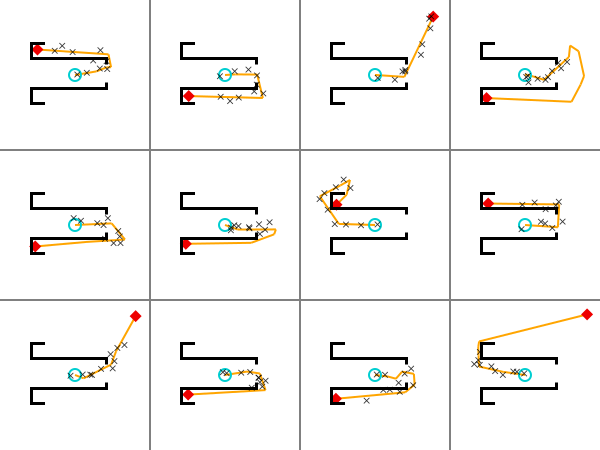

In [10]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    restaurant_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [11]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.60734, 0.50773)];
restaurant_visits = Vector{Int}(undef, 3);

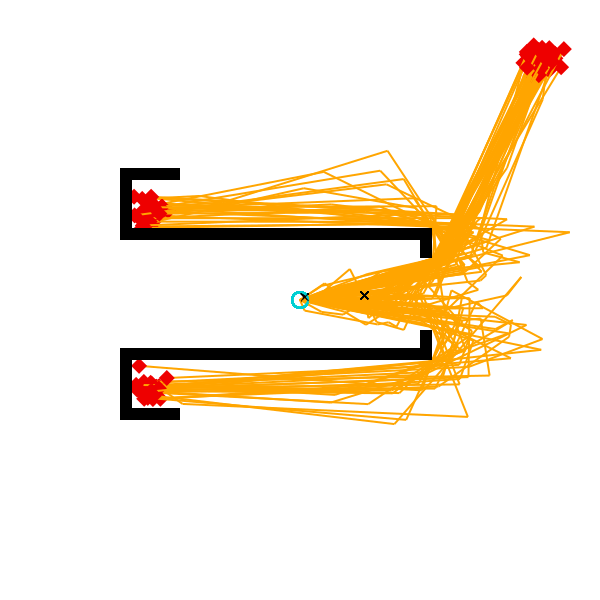

In [12]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [13]:
restaurant_visits

3-element Vector{Int64}:
 27
 28
 45

In [14]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.40734, 0.50773)];

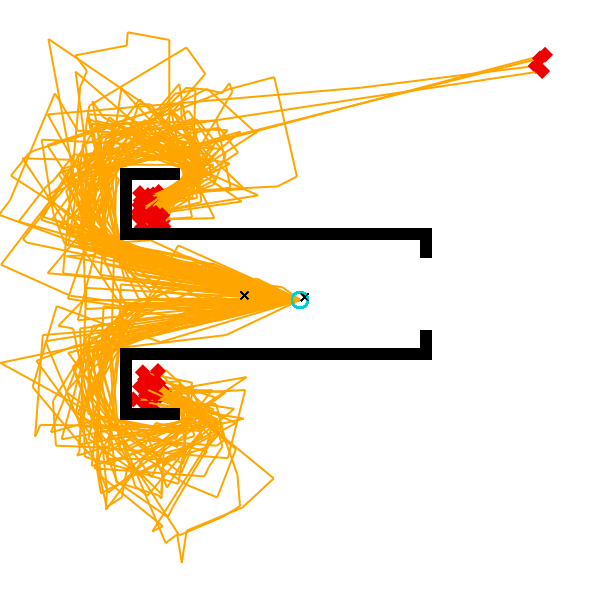

In [15]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [16]:
restaurant_visits

3-element Vector{Int64}:
 57
 39
  4

# Learning Waittimes

In [17]:
waittimes = DataFrame(Restaurant=[:A,:B, :A,:A,:C,:C], Waittime=[2., 5.5,2.2, 2.1, 1., 1.])

,Restaurant,Waittime
,Symbol,Float64
1,A,2.0
2,B,5.5
3,A,2.2
4,A,2.1
5,C,1.0
6,C,1.0


In [18]:
@gen function waittime_model(visits)
    w_bar ~ gamma(2, 1)
    w_i = Dict()
    w_i[:A] = {(:w_i, :A)} ~ gamma(w_bar, 1)
    w_i[:B] = {(:w_i, :B)} ~ gamma(w_bar, 1)
    w_i[:C] = {(:w_i, :C)} ~ gamma(w_bar, 1)
    
    
    waittimes = Vector{Float64}(undef,length(visits))
    for (i,v) in enumerate(visits)
       waittimes[i] = {(:waittime,i)} ~ gamma(w_i[v], 1)
    end
    return waittimes
end;

In [19]:
waittime_model(waittimes.Restaurant)

6-element Vector{Float64}:
 1.1211172839869563
 0.6266346576913956
 0.1784868840155314
 2.624158274472842
 1.6786831053857847
 1.940972150926293

In [20]:
observations = Gen.choicemap()

for (i,w) in enumerate(waittimes.Waittime)
    observations[(:waittime,i)] = w
end

traces = [importance_resampling(waittime_model, (waittimes.Restaurant,), observations, 100)[1] for _ in 1:100];

In [21]:
function get_waittimes(traces)
    choices = Gen.get_choices.(traces)
    w_bars = Gen.get_value.(choices, :w_bar)
    w_is = Dict()
    w_is[:A] = Vector{Float64}(undef, length(choices))
    w_is[:B] = Vector{Float64}(undef, length(choices))
    w_is[:C] = Vector{Float64}(undef, length(choices))
    for (i,choice) in enumerate(choices)
        w_is[:A][i] = Gen.get_value(choice, (:w_i,:A))
        w_is[:B][i] = Gen.get_value(choice, (:w_i,:B))
        w_is[:C][i] = Gen.get_value(choice, (:w_i,:C))
    end
    w_bars_m, w_bars_std = mean_and_std(w_bars)
    w_A_is_m, w_A_is_std = mean_and_std(w_is[:A])
    w_B_is_m, w_B_is_std = mean_and_std(w_is[:B])
    w_C_is_m, w_C_is_std = mean_and_std(w_is[:C])

    return (w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std)
end;

In [22]:
(w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std) = get_waittimes(traces)

((2.5073233909397543, 0.8285041526428375), (2.595110567423495, 0.8068478338764387), (3.9420972663043923, 1.453953659755014), (1.610085456807928, 0.674135062494824))

In [23]:
w_bars_ms = []
w_bars_stds = []

w_A_is_ms = []
w_A_is_stds = []

w_B_is_ms = []
w_B_is_stds = []


w_C_is_ms = []
w_C_is_stds = []


for i in 1:size(waittimes,1)  

    observations = Gen.choicemap()

    for (j,w) in enumerate(waittimes[1:i,:].Waittime)
        observations[(:waittime,j)] = w
    end

    traces = [importance_resampling(waittime_model, (waittimes[1:i,:].Restaurant,), observations, 100)[1] for _ in 1:100]
    (w_bar_m,w_bar_s),(w_A_i_m, w_A_i_s),(w_B_i_m, w_B_i_s),(w_C_i_m, w_C_i_s) = get_waittimes(traces)
    
    push!(w_bars_ms, w_bar_m)
    push!(w_bars_stds, w_bar_s)
    
    push!(w_A_is_ms, w_A_i_m)
    push!(w_A_is_stds, w_A_i_s)
    
    push!(w_B_is_ms, w_B_i_m)
    push!(w_B_is_stds, w_B_i_s)
    
    push!(w_C_is_ms, w_C_i_m)
    push!(w_C_is_stds, w_C_i_s)
    
end

w_bars_k = w_bars_ms .^ 2 ./ w_bars_stds .^ 2
w_bars_t = w_bars_stds .^ 2 ./ w_bars_ms

w_A_is_k = w_A_is_ms .^ 2 ./ w_A_is_stds .^ 2
w_A_is_t = w_A_is_stds .^2 ./ w_A_is_ms

w_B_is_k = w_B_is_ms .^ 2 ./ w_B_is_stds .^ 2
w_B_is_t = w_B_is_stds .^2 ./ w_B_is_ms

w_C_is_k = w_C_is_ms .^ 2 ./ w_C_is_stds .^ 2
w_C_is_t = w_C_is_stds .^2 ./ w_C_is_ms;

In [24]:
plts = Array{Any}(undef,(7,4))
colors = [:blue, :red, :green, :lightblue, :orange, :brown]
plts[1,1] = plot(Gamma(2, 1), title="Wbar 0", xlim=(0.,6.), ylim=(0., 0.45))
plts[1,2] = plot(Gamma(1, 1), title="W A 0", xlim=(0.,6.), ylim=(0., 0.45))
plts[1,3] = plot(Gamma(1, 1), title="W B 0", xlim=(0.,6.), ylim=(0., 0.45))
plts[1,4] = plot(Gamma(1, 1), title="W C 0", xlim=(0.,6.), ylim=(0., 0.45))
for i in 2:(size(waittimes, 1)+1)
    pos = waittimes.Waittime[i-1]
    restaurant = waittimes.Restaurant[i-1]
    plts[i,1] = plot(Gamma(w_bars_k[i-1], w_bars_t[i-1]), color=colors[i-1], title="Wbar $(i-1)", xlim=(0.,6.), ylim=(0., 0.45))
    plts[i,1] = plot!(plts[i,1], [pos], seriestype=:vline, color=:black)
    plts[i,2] = plot(Gamma(w_A_is_k[i-1], w_A_is_t[i-1]), color=colors[i-1], title="W A $(i-1)", xlim=(0.,6.), ylim=(0., 0.45))
    if restaurant == :A
        plts[i,2] = plot!(plts[i,2], [pos], seriestype=:vline, color=:black)
    end
    plts[i,3] = plot(Gamma(w_B_is_k[i-1], w_B_is_t[i-1]), color=colors[i-1], title="W B $(i-1)", xlim=(0.,6.), ylim=(0., 0.45))
    if restaurant == :B
        plts[i,3] = plot!(plts[i,3], [pos], seriestype=:vline, color=:black)
    end
    plts[i,4] = plot(Gamma(w_C_is_k[i-1], w_C_is_t[i-1]), color=colors[i-1], title="W C $(i-1)", xlim=(0.,6.), ylim=(0., 0.45))
     if restaurant == :C
        plts[i,4] = plot!(plts[i,4], [pos], seriestype=:vline, color=:black)
    end
end

┌ Info: Saved animation to 
│   fn = /home/lukas/Dev/Julia/problang_rethink/src/wbar.gif
└ @ Plots /home/lukas/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/lukas/Dev/Julia/problang_rethink/src/wbar.gif")
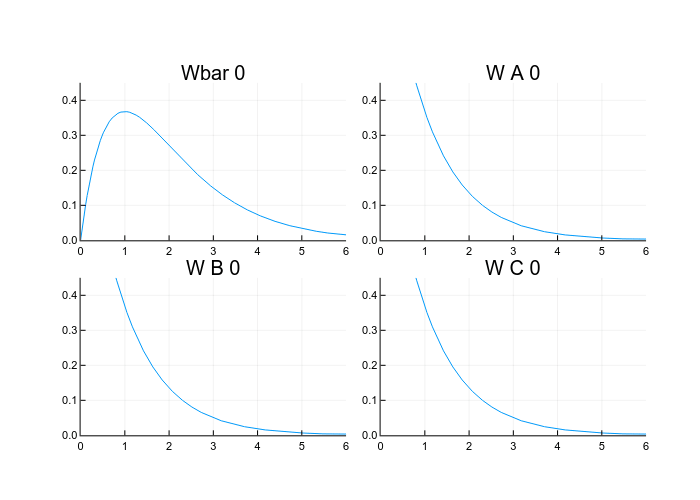

In [25]:
anim = @animate for i in 1:7
    plot(plts[i, 1:4]..., legend=false)
end
gif(anim, "wbar.gif", fps=0.5)

In [26]:
plot(plts[1, 1:4]..., legend=false)

In [27]:
plot(plts[2, 1:4]..., legend=false)

In [28]:
plot(plts[3, 1:4]..., legend=false)

In [29]:
plot(plts[4, 1:4]..., legend=false)

In [30]:
plot(plts[5, 1:4]..., legend=false)

In [31]:
plot(plts[6, 1:4]..., legend=false)

In [32]:
plot(plts[7, 1:4]..., legend=false)

In [33]:
waiting_time = [w_A_is_m, w_B_is_m, w_C_is_m]

3-element Vector{Float64}:
 2.595110567423495
 3.9420972663043923
 1.610085456807928

# Chosing a Restaurant

In [34]:
preference = [0.7, 1.1, 1.3]

3-element Vector{Float64}:
 0.7
 1.1
 1.3

In [35]:
@gen function complex_agent_datasource(waiting_times, preference, emotion)
    un_probs = exp.((.- waiting_times ./ sum(waiting_times)) .+ preference ./ sum(preference) .+ emotion ./ sum(emotion))
    probs = un_probs ./ sum(un_probs)
    choice ~ categorical(probs)
    return choice
end;

# Statistical Analysis

In [36]:
data_vector = [complex_agent_datasource(waiting_time, preference, restaurant_visits) for _ in 1:140];

In [37]:
data = DataFrame(RestaurantChoice=data_vector);

In [38]:
[waiting_time preference restaurant_visits]

3×3 Matrix{Float64}:
 2.59511  0.7  57.0
 3.9421   1.1  39.0
 1.61009  1.3   4.0

In [39]:
@df data plot(:RestaurantChoice, seriestype=:histogram)

In [40]:
visits = zeros(Int, 3)

for i in 1:3
    visits[i] = sum(data.RestaurantChoice .== i)
end

In [41]:
prices = [3., 2.5, 1.]

3-element Vector{Float64}:
 3.0
 2.5
 1.0

In [42]:
qualities = [0.7, 0.5, 0.7]

3-element Vector{Float64}:
 0.7
 0.5
 0.7

In [43]:
staff = [0.5, 0.2, 1.]

3-element Vector{Float64}:
 0.5
 0.2
 1.0

In [44]:
@gen function visit_full_model(prices, qualities, staff)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)
    quality_slope ~ normal(0,15)
    staff_slope ~ normal(0,15)
    
    noise ~ gamma(1,1)
    
    
    function f(price, quality, staff)
        return intercept + price * price_slope + quality * quality_slope + staff * staff_slope
    end
    
    for (i,p) in enumerate(prices)
        q = qualities[i]
        s = staff[i]
        {(:visits, i)} ~ normal(f(p,q,s), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##visit_full_model#314", Bool[0, 0, 0], false)

In [45]:
traces = [importance_resampling(visit_full_model,
    (prices, qualities, staff), observations, 50,
    verbose=false)[1] for _ in 1:100]
lines = Gen.get_retval.(traces);

In [46]:
test_xs = range(0, 4, length=100)
plot(test_xs, [f.(test_xs, [0.5 for _ in 1:100], [0.5 for _ in 1:100]) for f in lines], legend=false)

In [47]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], test_xs, [0.5 for _ in 1:20]) for f in lines], legend=false)

In [48]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], [0.5 for _ in 1:20], test_xs) for f in lines], legend=false)

In [49]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
quality_slopes = Gen.get_value.(choices, :quality_slope)
staff_slopes = Gen.get_value.(choices, :staff_slope)
noises = Gen.get_value.(choices, :noise);

In [50]:
plot(price_slopes, bins=25, seriestype=:histogram, legend=false)

In [51]:
plot(quality_slopes, bins=35, seriestype=:histogram, legend=false)

In [52]:
plot(staff_slopes, bins=35, seriestype=:histogram, legend=false)

## Predictive Distribution

In [53]:
sample_intercept_mu, sample_intercept_std = mean_and_std(intercepts) 

(32.1286217224779, 31.885966789316694)

In [54]:
plot(intercepts, seriestype=:density, label="Sample")
plot!(Normal(sample_intercept_mu, sample_intercept_std), label="Predictive")
plot!(Normal(30, 30), label="Prior")

In [55]:
sample_price_slope_mu, sample_price_slope_std = mean_and_std(price_slopes) 

(1.9248827927031278, 16.659136729974453)

In [56]:
plot(price_slopes, seriestype=:density, label="Sample", title="Noise")
plot!(Normal(sample_price_slope_mu, sample_price_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [57]:
sample_quality_slope_mu, sample_quality_slope_std = mean_and_std(quality_slopes)

(1.4588508824977766, 14.051327518130531)

In [58]:
plot(quality_slopes, seriestype=:density, label="Sample", title="Quality")
plot!(Normal(sample_quality_slope_mu, sample_quality_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [59]:
sample_staff_slope_mu, sample_staff_slope_std = mean_and_std(staff_slopes)

(1.876378340422925, 16.00139890093966)

In [60]:
plot(staff_slopes, seriestype=:density, label="Sample", title="Staff")
plot!(Normal(sample_staff_slope_mu, sample_staff_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [61]:
sample_noises_mu, sample_noises_std = mean_and_std(noises)

(1.0111560992879114, 0.9695956742778763)

In [62]:
plot(noises, seriestype=:density, label="Sample", title="Noise")
# plot!(Normal(sample_noises_mu, sample_noises_std), label="Predictive")
plot!(Gamma(1, 1), label="Prior")